In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading and Exploring data

In [2]:
# load data
import numpy as np
x_data = np.load("/content/drive/My Drive/x_digits.npy")
y_data=np.load("/content/drive/My Drive/y_digits.npy")

In [3]:
# Data Exploration
print("X shape: ", x_data.shape)
print("Y shape: ", y_data.shape)


X shape:  (35631, 129, 71)
Y shape:  (35631,)


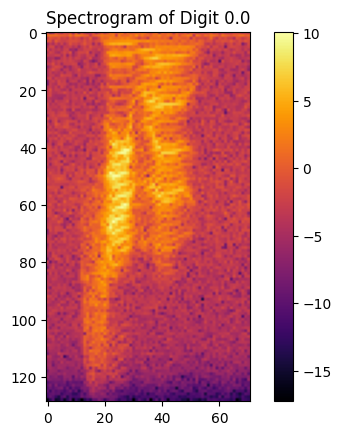

In [4]:
import matplotlib.pyplot as plt

plt.imshow(x_data[0], cmap='inferno')
plt.title(f"Spectrogram of Digit {y_data[0]}")
plt.colorbar()
plt.show()


In [5]:
# to see how many times each number appears in the dataset to have certain understanding
import numpy as np

unique, counts = np.unique(y_data, return_counts=True)
print(dict(zip(unique, counts)))


{0.0: 3757, 1.0: 3492, 2.0: 3525, 3.0: 3403, 4.0: 3403, 5.0: 3727, 6.0: 3598, 7.0: 3668, 8.0: 3429, 9.0: 3629}


In [6]:
# split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, stratify= y_data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify= y_train)
x_train,x_val,x_test=X_train/255.,X_val/255.,X_test/255.

print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (20042, 129, 71)
X_val shape:  (6681, 129, 71)
X_test shape:  (8908, 129, 71)


# FCNN

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import AdamW, RMSprop, SGD,Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Function to build FCNN model
def build_fcnn(optimizer, dropout_rate=0.2):
    model = Sequential([
        tf.keras.layers.Input(shape=(129, 71)),
        Flatten(),
        Dense(124, activation='swish', kernel_initializer="he_normal"),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(124, activation='swish', kernel_initializer="he_normal"),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(124, activation='swish', kernel_initializer="he_normal"),
        BatchNormalization(),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
# Define optimizers
optimizers = {
    'Adam': Adam(learning_rate=0.0005),
    'RMSprop': RMSprop(learning_rate=0.0005),
    'NAG': SGD(learning_rate=0.0005, momentum=0.75, nesterov=True)
}

In [9]:
# Train models and store histories
histories = {}
for opt_name, opt in optimizers.items():
    print(f'Training with {opt_name}...')
    model = build_fcnn(opt)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)
    histories[opt_name] = history

Training with Adam...
Epoch 1/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3007 - loss: 2.0789 - val_accuracy: 0.5897 - val_loss: 1.2665
Epoch 2/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5407 - loss: 1.3313 - val_accuracy: 0.6319 - val_loss: 1.0438
Epoch 3/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6155 - loss: 1.1101 - val_accuracy: 0.7234 - val_loss: 0.8328
Epoch 4/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6603 - loss: 0.9809 - val_accuracy: 0.7203 - val_loss: 0.8229
Epoch 5/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6888 - loss: 0.8976 - val_accuracy: 0.7479 - val_loss: 0.7486
Epoch 6/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7127 - loss: 0.8449 - val_accuracy: 0.7777 - val_loss: 0.6751
Epoch 7/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7376 - loss: 0.7717 - val_accuracy: 0.7446 - val_loss: 0.7342
Epoch 8/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7330 - loss: 0.

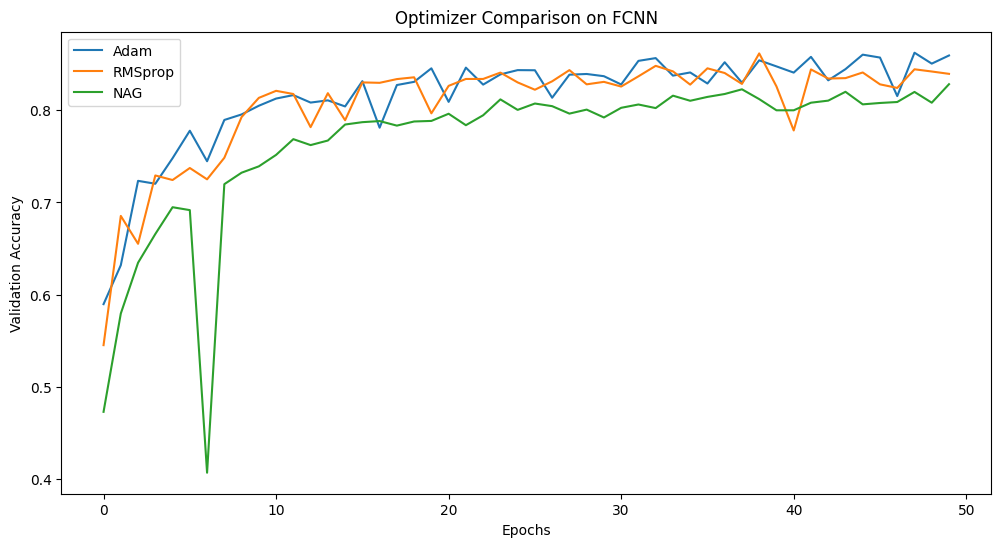

In [10]:
# Plot validation accuracy for different optimizers
plt.figure(figsize=(12, 6))
for opt_name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=f'{opt_name}')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Optimizer Comparison on FCNN')
plt.show()

The RMSProp optimizer proved to be the best choice because it achieved the highest training accuracy, the best validation accuracy, and the lowest validation loss.

Key takeaways so far:
*   Normalization played a crucial role in improving optimization.
*   Reducing the learning rate from 0.1 to 0.005 significantly helped.
*   Before applying batch normalization, the accuracy for all optimizers was limited to a maximum of 50%.

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
# choosing best optimizer
print("Training with ADAM: ")
best_model = build_fcnn(Adam(learning_rate=0.0005))
callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
best_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=callbacks, verbose=1)

Training with ADAM: 
Epoch 1/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.2967 - loss: 2.1230 - val_accuracy: 0.5028 - val_loss: 1.4490
Epoch 2/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5527 - loss: 1.2928 - val_accuracy: 0.6652 - val_loss: 0.9813
Epoch 3/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6360 - loss: 1.0670 - val_accuracy: 0.6906 - val_loss: 0.9202
Epoch 4/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6806 - loss: 0.9377 - val_accuracy: 0.7123 - val_loss: 0.8439
Epoch 5/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7121 - loss: 0.8573 - val_accuracy: 0.7304 - val_loss: 0.8082
Epoch 6/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7386 - loss: 0.7621 - val_accuracy: 0.7973 - val_loss: 0.6213
Epoch 7/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7577 - loss: 0.7202 - val_accuracy: 0.7738 - val_loss: 0.6847
Epoch 8/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7742 - l

In [14]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"FCNN Test Accuracy: {test_accuracy:.4f} - Test Loss: {test_loss:.4f}")

279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8403 - loss: 0.4753
FCNN Test Accuracy: 0.8389 - Test Loss: 0.4805


# CNN

In [15]:
X_train_cnn = X_train.reshape([-1, 129, 71, 1])
X_valid_cnn = X_val.reshape([-1, 129, 71, 1])
X_test_cnn = X_test.reshape([-1, 129, 71, 1])

print(f"x_train shape: {X_train_cnn.shape}")
print(f"x_valid shape: {X_valid_cnn.shape}")
print(f"x_test shape: {X_test_cnn.shape}")


x_train shape: (20042, 129, 71, 1)
x_valid shape: (6681, 129, 71, 1)
x_test shape: (8908, 129, 71, 1)


In [22]:
def build_cnn():
    model = Sequential([
        layers.Input(X_train_cnn[0].shape),
        layers.Conv2D(16, (3,3), activation = "swish", kernel_initializer = "he_normal"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3,3), activation = "swish", kernel_initializer = "he_normal"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3,3), activation = "swish", kernel_initializer = "he_normal"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(64, activation = "swish", kernel_initializer = "he_normal"),
        layers.Dense(32, activation = "swish", kernel_initializer = "he_normal"),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)

model = build_cnn()
history = model.fit(
    X_train_cnn, y_train,
    epochs=30,
    validation_data=(X_valid_cnn, y_val),
    callbacks=[early_stopping_cb, lr_scheduler]
)

Epoch 1/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.1995 - loss: 3.0811 - val_accuracy: 0.5200 - val_loss: 1.4326 - learning_rate: 5.0000e-04
Epoch 2/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5523 - loss: 1.3102 - val_accuracy: 0.7649 - val_loss: 0.7386 - learning_rate: 5.0000e-04
Epoch 3/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7850 - loss: 0.6546 - val_accuracy: 0.8608 - val_loss: 0.4449 - learning_rate: 5.0000e-04
Epoch 4/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8705 - loss: 0.3913 - val_accuracy: 0.8985 - val_loss: 0.3155 - learning_rate: 5.0000e-04
Epoch 5/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9138 - loss: 0.2632 - val_accuracy: 0.9063 - val_loss: 0.2984 - learning_rate: 5.0000e-04
Epoch 6/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9297 - loss: 0.2038 - val_accuracy: 0.9091 - val_loss: 0.2929 - learning_rate: 5.0000e-04
Epoch 7/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 

**learning from CNN:**

*   earlyStopping and ReduceLROnPlateau helped in fast learning
*   Swish performed here too in comparison to other activation function
*   Three convolutional layers provides an optimal balance too.

In [23]:
print(" CNN Loss + accuracy on test data: {}".format(model.evaluate(X_test_cnn, y_test)))

279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9405 - loss: 0.2717
 CNN Loss + accuracy on test data: [0.2563173472881317, 0.9436461329460144]


CNN clearly performs better with accuracy of 95% on test data while FCNN with 83% of accuracy.

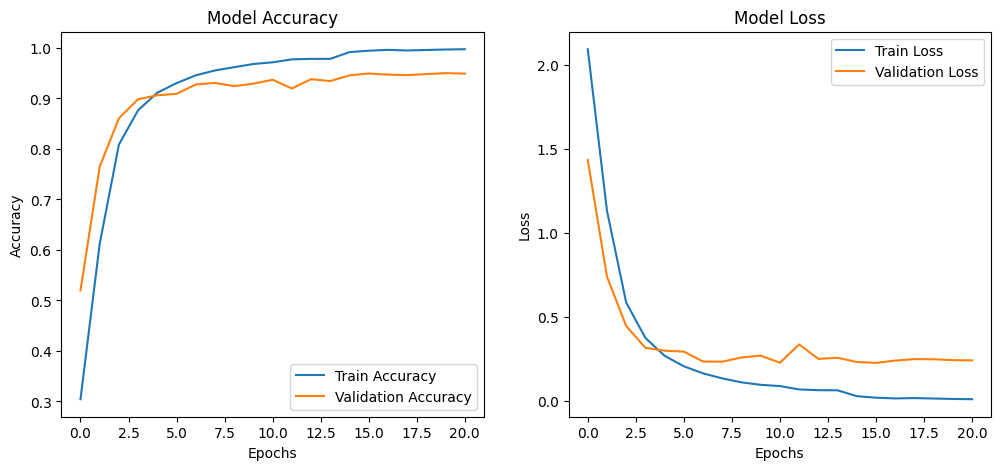

In [24]:
#plot training curves
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy plot
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Loss plot
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()

plot_training_history(history)


279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


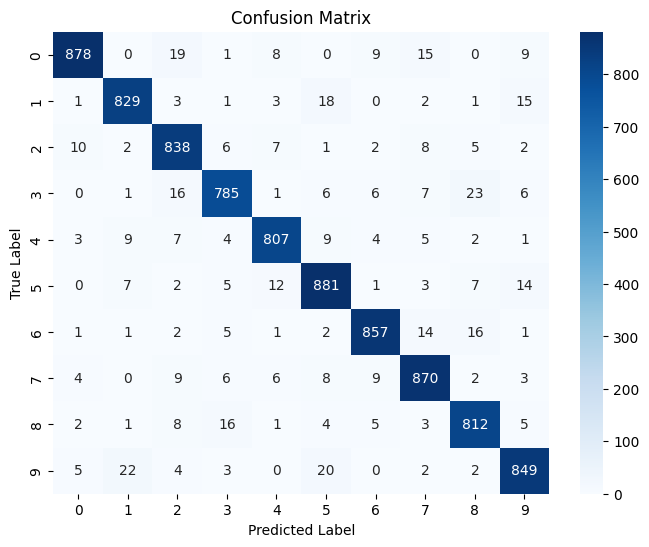

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions
y_pred = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


**Most Problematic Misclassifications:**

  **Class 9 has the most notable misclassifications:**
*   22 samples of class 9 were incorrectly classified as class 1
*   20 samples of class 9 were incorrectly classified as class 5

  **Class 3 shows some confusion:**
*   23 samples of class 3 were misclassified as class 8
*   16 samples of class 3 were misclassified as class 2

**Other notable cross-class confusions:**
*   Class 1 has 18 samples misclassified as class 4
*   Class 5 has 14 samples misclassified as class 6
*   Class 7 has 16 samples misclassified as class 8

**Best Performing Classes:**
*   Class 0 is the most accurately classified, with 878 correct predictions
*   Class 2 and Class 7 also show high accuracy with 838 and 870 correct predictions respectively

**Most Confused Pairs:**


1.   Class 9 and Class 1
2.   Class 3 and Class 8
3.   Class 5 and Class 6
4.   Class 1 and Class 4



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


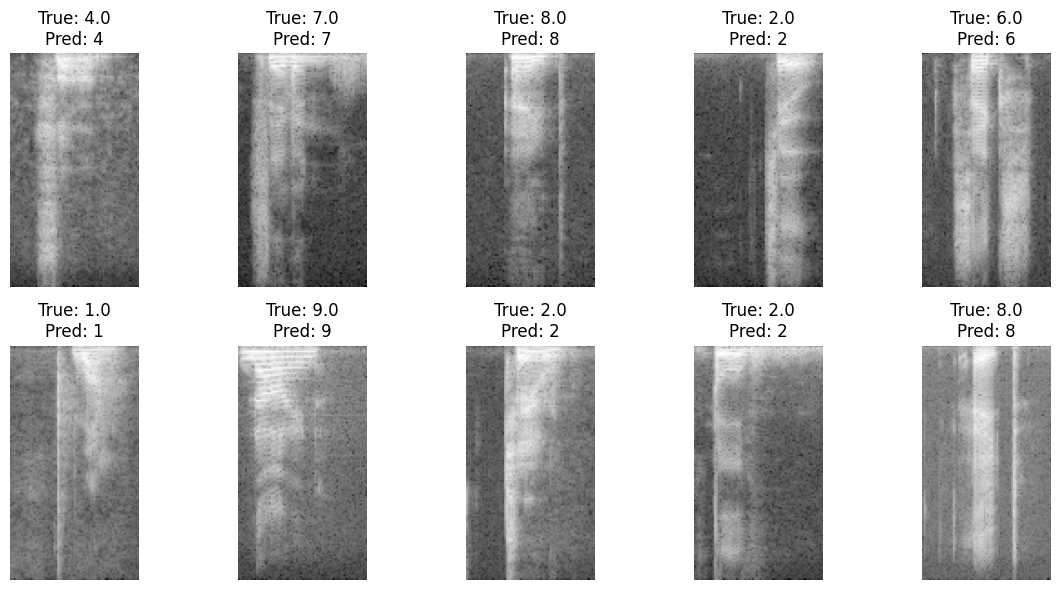

In [26]:
import random

# Pick random samples from test set
num_samples = 10
indices = random.sample(range(len(X_test_cnn)), num_samples)
X_sample = X_test_cnn[indices]
y_sample_true = y_test[indices]

# Get model predictions
y_sample_pred = np.argmax(model.predict(X_sample), axis=1)

# Plot images with predictions
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(X_sample[i].reshape(129, 71), cmap='gray')  # Reshape for display
    ax.set_title(f"True: {y_sample_true[i]}\nPred: {y_sample_pred[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [27]:
# missclasssified example
# Get model predictions
y_pred = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Find misclassified indices
misclassified_indices = np.where(y_pred_classes != y_test)[0]

print(f"Total Misclassified Samples: {len(misclassified_indices)}")


279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Total Misclassified Samples: 502


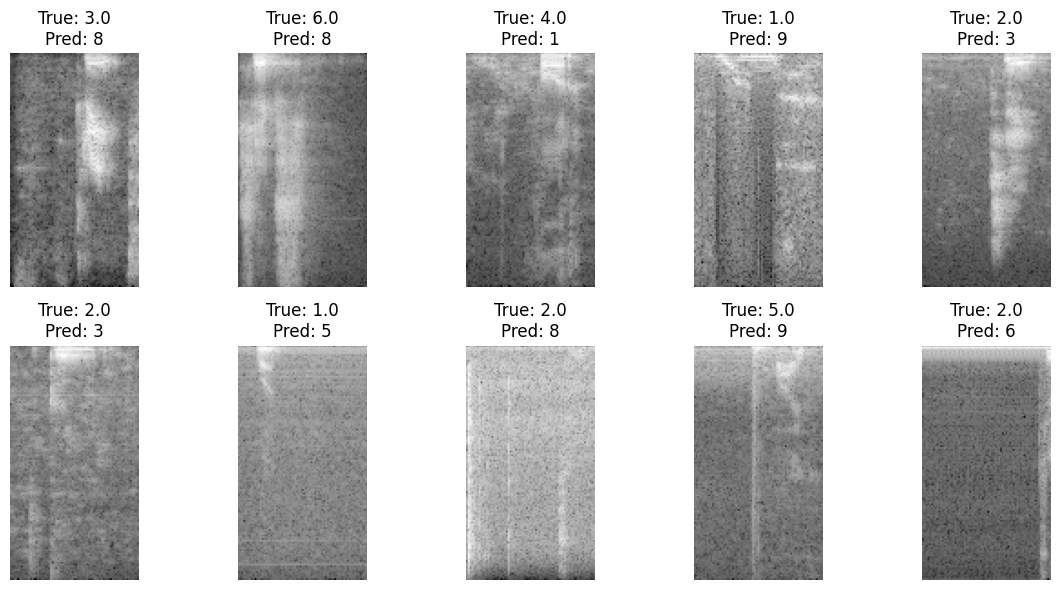

In [28]:
import random

# Select random misclassified samples
num_samples = 10
random_indices = random.sample(list(misclassified_indices), min(num_samples, len(misclassified_indices)))

# Extract data
X_misclassified = X_test_cnn[random_indices]
y_true_misclassified = y_test[random_indices]
y_pred_misclassified = y_pred_classes[random_indices]

# Plot misclassified images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(X_misclassified[i].reshape(129, 71), cmap='gray')  # Reshape for display
    ax.set_title(f"True: {y_true_misclassified[i]}\nPred: {y_pred_misclassified[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


From the overall analysis, I got to conclusion that CNN performed better than FCNN and also there were only 502 misclassified samples overall.